# Organoid Validation

In [1]:
import logging
import os
import random

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Circle

from src.config import conf

random.seed(conf.seed)

_logger = logging.getLogger(__name__)

import matplotlib.font_manager as fm

if any("Arial" in f.name for f in fm.fontManager.ttflist):
    plt.rcParams["font.family"] = "Arial"

## Calcitriol Treatment Data

Read aggregated proteomics data. WASP code to analyze proteomics data is available at [`Wyss-BD2/WASP3`](https://github.com/Wyss-BD2/WASP3).

In [ ]:
bd_u = pd.read_csv(conf.paths.notebooks.organoid_validation_dir / "bd vs control" / "aggregated_protein_matrix.csv")
bd_u.set_index("Accession", inplace=True)
bd_t = pd.read_csv(conf.paths.notebooks.organoid_validation_dir / "bd calc vs bd" / "aggregated_protein_matrix.csv")
bd_t.set_index("Accession", inplace=True)
isect = pd.read_csv(conf.paths.notebooks.organoid_validation_dir / "intersection.csv")
isect_set = isect.dropna(subset="All-for heatmap")["All-for heatmap"].to_list()
gene = pd.read_csv(conf.paths.notebooks.organoid_validation_dir / "gene_list.csv", index_col=0).dropna(subset="Entry")

In [ ]:
df_ctrl_vs_bdu = bd_u
df_ctrl_vs_bdt = bd_t

# Identify control columns
control_cols_bdu = df_ctrl_vs_bdu.columns[df_ctrl_vs_bdu.columns.str.contains("_25|_15|_24|_12|_21", case=False)]
control_cols_bdt = df_ctrl_vs_bdt.columns[df_ctrl_vs_bdt.columns.str.contains("_25|_15|_24|_12|_21", case=False)]

# Get shared proteins
shared_proteins = df_ctrl_vs_bdu.index.intersection(df_ctrl_vs_bdt.index)
df1 = df_ctrl_vs_bdu.loc[shared_proteins]
df2 = df_ctrl_vs_bdt.loc[shared_proteins]

# Compute average control values per protein in each run
mean_control_bdu = df1[control_cols_bdu].mean(axis=1)
mean_control_bdt = df2[control_cols_bdt].mean(axis=1)

# Compute shift per protein to normalize treated to control
per_protein_shift = mean_control_bdu - mean_control_bdt
df2_normed = df2.add(per_protein_shift, axis=0)
df2_normed = df2_normed.drop(columns=control_cols_bdt)
combined_df = pd.concat([df1, df2_normed], axis=1)

_logger.info(f"Combined normalized matrix shape: {combined_df.shape}")

[12/04/25 19:55:13] INFO     Combined normalized matrix shape: (9545, 14)                           ]8;id=234053;file:///tmp/ipykernel_3136061/997911632.py\997911632.py]8;;\:]8;id=146316;file:///tmp/ipykernel_3136061/997911632.py#36\36]8;;\

Plot heatmap of normalized proteomics data.

In [ ]:
cdf = combined_df.merge(gene, left_index=True, right_index=True, how="inner").reset_index(drop=True).set_index("Entry")
hm = cdf[cdf.index.isin(isect_set)].copy()

hm.rename(
    columns={
        "Area 051625A_BD2_OrganoidsCV54_18": "CM3",
        "Area 051625A_BD2_OrganoidsCV54_3": "CM2",
        "Area 051625A_BD2_OrganoidsCV54_6_2": "CM4",
        "Area 051625A_BD2_OrganoidsCV54_9_2": "CF4",
        "Area 051625A_BD2_OrganoidsCV54_12": "BF5_U",
        "Area 051625A_BD2_OrganoidsCV54_15_2": "BF3_U",
        "Area 051925A_BD2_OrganoidsCV54_21_3": "BM4_U",
        "Area 051925A_BD2_OrganoidsCV54_24_3": "BF4_U",
        "Area 051925A_BD2_OrganoidsCV54_25_3": "BF1_U",
        "Area 051625A_BD2_OrganoidsCV54_11": "BF5_T",
        "Area 051625A_BD2_OrganoidsCV54_14_2": "BF3_T",
        "Area 051625A_BD2_OrganoidsCV54_20": "BM4_T",
        "Area 051625A_BD2_OrganoidsCV54_23": "BF4_T",
        "Area 051925A_BD2_OrganoidsCV54_26_3": "BF1_T",
    },
    inplace=True,
)

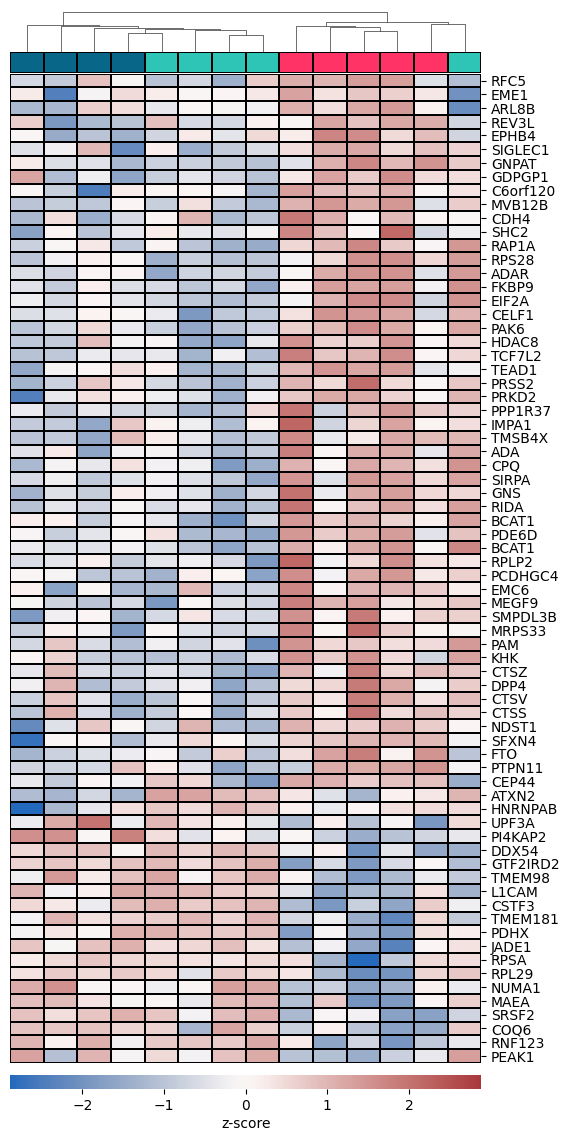

In [ ]:
# Compute z-scores over rows
hm_z = hm.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
hm_z.index = hm_z.index.str.replace(r"-\d+$", "", regex=True)

col_colors = pd.Series(
    [
        "#086788"
        if "c" in c.lower()
        else "#FF3366"
        if "_u" in c.lower()
        else "#2EC4B6"
        if "_t" in c.lower()
        else "gray"
        for c in hm_z.columns
    ],
    index=hm_z.columns,
)

g = sns.clustermap(
    hm_z,
    z_score=None,
    col_cluster=True,
    row_cluster=True,
    dendrogram_ratio=(0.001, 0.04),
    col_colors=col_colors,
    cmap="vlag",
    linewidths=0.2,
    linecolor="black",
    figsize=(6, 12),
    xticklabels=False,
    yticklabels=True,
    colors_ratio=0.02,
    cbar_pos=None,
    center=0,
)

g.ax_row_dendrogram.remove()
g.figure.subplots_adjust(bottom=0.11)
g.ax_heatmap.set_ylabel("")

# Horizontal color bar
v = max(abs(hm_z.values.min()), abs(hm_z.values.max()))
hm_pos = g.ax_heatmap.get_position()
cb_height = 0.012
cb_gap = 0.01
cb_ax = g.figure.add_axes([
    hm_pos.x0,
    hm_pos.y0 - cb_gap - cb_height,
    hm_pos.width,
    cb_height,
])

sm = plt.cm.ScalarMappable(cmap="vlag", norm=plt.Normalize(-v, v))
sm.set_array([])
cbar = g.figure.colorbar(sm, cax=cb_ax, orientation="horizontal", drawedges=False)
cbar.set_label("z-score", labelpad=3)
cbar.outline.set_visible(False)
cb_ax.set_frame_on(False)

# Remove labels around the color bar
if hasattr(g, "ax_col_colors"):
    g.ax_col_colors.set_xticks([])
    g.ax_col_colors.set_yticks([])
    g.ax_col_colors.tick_params(axis="both", length=0)
    g.ax_col_colors.set_frame_on(False)

plt.savefig(conf.paths.notebooks.organoid_validation_dir / "heatmap.svg", format="svg", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.organoid_validation_dir / "heatmap.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Lithium Treatment Data

In [ ]:
bd_u = pd.read_csv(conf.paths.notebooks.organoid_validation_dir / "bd calc vs bd" / "aggregated_protein_matrix.csv")
bd_u.set_index("Accession", inplace=True)
bd_t = pd.read_csv(conf.paths.notebooks.organoid_validation_dir / "BDLiOro_vs_BD" / "aggregated_protein_matrix.csv")
bd_t.set_index("Accession", inplace=True)
isect = pd.read_excel(conf.paths.notebooks.organoid_validation_dir / "gene.xlsx")
isect_set = isect.dropna(subset="Gene")["Gene"].to_list()
gene = pd.read_csv(conf.paths.notebooks.organoid_validation_dir / "gene_list.csv", index_col=0).dropna(subset="Entry")

In [ ]:
df_ctrl_vs_bdu = bd_u
df_ctrl_vs_bdt = bd_t

# Identify control columns
control_cols_bdu = df_ctrl_vs_bdu.columns[df_ctrl_vs_bdu.columns.str.contains("_25|_15|_24|_12|_21", case=False)]
control_cols_bdt = df_ctrl_vs_bdt.columns[df_ctrl_vs_bdt.columns.str.contains("un", case=False)]

# Get shared proteins
shared_proteins = df_ctrl_vs_bdu.index.intersection(df_ctrl_vs_bdt.index)
df1 = df_ctrl_vs_bdu.loc[shared_proteins]
df2 = df_ctrl_vs_bdt.loc[shared_proteins]

# Compute average control values per protein in each run
mean_control_bdu = df1[control_cols_bdu].mean(axis=1)
mean_control_bdt = df2[control_cols_bdt].mean(axis=1)

# Compute shift per protein to normalize treated to control
per_protein_shift = mean_control_bdu - mean_control_bdt
df2_normed = df2.add(per_protein_shift, axis=0)
df2_normed = df2_normed.drop(columns=control_cols_bdt)
combined_df = pd.concat([df1, df2_normed], axis=1)

_logger.info("Combined normalized matrix shape: %s", combined_df.shape)

[12/04/25 19:55:15] INFO     Combined normalized matrix shape: (9044, 13)                          ]8;id=91161;file:///tmp/ipykernel_3136061/3323455741.py\3323455741.py]8;;\:]8;id=619176;file:///tmp/ipykernel_3136061/3323455741.py#36\36]8;;\

Make a heatmap of normalized proteomics data.

In [ ]:
cdf = combined_df.merge(gene, left_index=True, right_index=True, how="inner").reset_index(drop=True).set_index("Entry")
hm = cdf[cdf.index.isin(isect_set)].copy()

hm.rename(
    columns={
        "Area 051625A_BD2_OrganoidsCV54_12": "BF5_U",
        "Area 051625A_BD2_OrganoidsCV54_15_2": "BF3_U",
        "Area 051925A_BD2_OrganoidsCV54_21_3": "BM4_U",
        "Area 051925A_BD2_OrganoidsCV54_24_3": "BF4_U",
        "Area 051925A_BD2_OrganoidsCV54_25_3": "BF1_U",
        "Area 051625A_BD2_OrganoidsCV54_11": "BF5_C",
        "Area 051625A_BD2_OrganoidsCV54_14_2": "BF3_C",
        "Area 051625A_BD2_OrganoidsCV54_20": "BM4_C",
        "Area 051625A_BD2_OrganoidsCV54_23": "BF4_C",
        "Area 051925A_BD2_OrganoidsCV54_26_3": "BF1_C",
        "Area 061225A_BD2_CV30_BF1_LiO": "BF1_Li",
        "Area 061225A_BD2_CV30_BF5_LiO": "BF5_Li",
        "Area 061225A_BD2_CV30_BM3_LiO": "BM3_Li",
    },
    inplace=True,
)

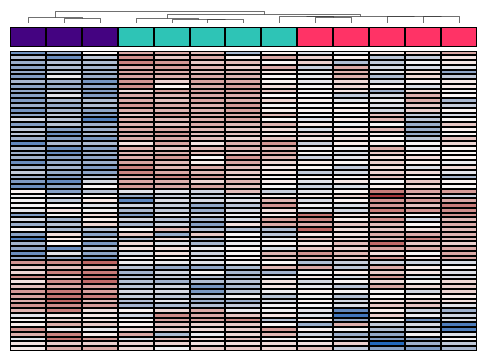

In [ ]:
# Compute z-scores over rows
hm_z = hm.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
hm_z.index = hm_z.index.str.replace(r"-\d+$", "", regex=True)

# Column color strip
col_colors = pd.Series(
    [
        "#FF3366"
        if "_u" in c.lower()
        else "#2EC4B6"
        if "_c" in c.lower()
        else "#440381"
        if "_li" in c.lower()
        else "gray"
        for c in hm_z.columns
    ],
    index=hm_z.columns,
)

g = sns.clustermap(
    hm_z,
    z_score=None,
    col_cluster=True,
    row_cluster=True,
    dendrogram_ratio=(0.001, 0.04),
    col_colors=col_colors,
    cmap="vlag",
    linewidths=0.1,
    linecolor="black",
    figsize=(6, 4),
    xticklabels=False,
    yticklabels=True,
    colors_ratio=0.06,
    cbar_pos=None,
    center=0,
)

g.ax_row_dendrogram.remove()
g.figure.subplots_adjust(bottom=0.11)
g.ax_heatmap.set_ylabel("")
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels([])

# Remove labels around the column-colour bar
if hasattr(g, "ax_col_colors"):
    g.ax_col_colors.set_xticks([])
    g.ax_col_colors.set_yticks([])
    g.ax_col_colors.tick_params(axis="both", length=0)
    g.ax_col_colors.set_frame_on(False)

plt.savefig(conf.paths.notebooks.organoid_validation_dir / "lithium_heatmap.svg", format="svg", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.organoid_validation_dir / "lithium_heatmap.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Treatment-Affected Pathways

Read Sankey data and create dumbell charts.

In [ ]:
# Read data
pathway_df = pd.read_excel(conf.paths.notebooks.organoid_validation_dir / "sankey-key.xlsx", sheet_name="sankey_data")

# Set colors
CTRL_COL = "#086788"  # BD vs Control
TREAT_COL = "#2EC4B6"  # BD vs Drug‑treated BD
ZERO_LINE = "#FF3366"  # vertical reference line

# Keep only complete pairs
wide = pathway_df.dropna(subset=["logFC_BD_UTR_CTR", "logFC_BD_BD_calc"]).rename(
    columns={
        "logFC_BD_UTR_CTR": "logFC_Control",
        "logFC_BD_BD_calc": "logFC_Treatment",
        "pVal_BD_UTR_CTR": "pVal_Control",
        "pVal_BD_BD_calc": "pVal_Treatment",
    }
)

# Draw dumbbell chart
def draw_dumbbell(data, ax):
    data = data.sort_values("logFC_Treatment")
    y = range(len(data))

    def get_point_size(p_val):
        if p_val <= 0.01:
            return 100 
        elif p_val < 0.05:
            return 50
        else:
            return 10
    
    ctrl_sizes = [get_point_size(p) for p in data["pVal_Control"]]
    treat_sizes = [get_point_size(p) for p in data["pVal_Treatment"]]

    # Make connectors
    ax.hlines(y, data["logFC_Control"], data["logFC_Treatment"], color="lightgray", linewidth=1)

    # Dots with size based on p-values
    ax.scatter(data["logFC_Control"], y, color=CTRL_COL, s=ctrl_sizes, zorder=3, label="BD vs. Control")
    ax.scatter(data["logFC_Treatment"], y, color=TREAT_COL, s=treat_sizes, zorder=3, label="BD vs. Drug-treated BD")
    ax.axvline(0, c=ZERO_LINE, ls="--", lw=0.8)
    ax.set_yticks(y)

    # Get protein labels
    y_labels = [label.split("-")[0] for label in data["protein"]]
    ax.set_yticklabels(y_labels)
    ax.set_xlabel("log$_2$ fold-change")
    ax.set_ylabel("")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylim(-0.5, len(data) - 0.5)


# Pathway-specific aspect ratios
aspect_map = {
    "Metabolism and protein homeostasis": 1.2,
    "Ribosome, translation, and RNA processing": 0.8,
    "Synapse, adhesion, and cytoskeleton": 0.5,
}

out_dir = conf.paths.notebooks.organoid_validation_dir / "dumbbells"

for pathway, df_path in wide.groupby("pathway", sort=False):
    w, h = 4, 4 * aspect_map.get(pathway, 1)
    fig, ax = plt.subplots(figsize=(w, h))

    draw_dumbbell(df_path, ax=ax)
    ax.set_title(pathway)

    plt.tight_layout()
    os.makedirs(out_dir, exist_ok=True)
    fname = out_dir / f"{pathway.replace(' ', '_').replace(',', '').lower()}"
    fig.savefig(fname.with_suffix(".pdf"), bbox_inches="tight")
    fig.savefig(fname.with_suffix(".svg"), bbox_inches="tight")
    plt.close(fig)

In [14]:
# Create a separate legend figure
legend_fig, legend_ax = plt.subplots(figsize=(6, 2))
legend_ax.axis("off")

legend_handles = [
    Circle((0, 0), radius=0.5, color=CTRL_COL, label="BD vs. Control"),
    Circle((0, 0), radius=0.5, color=TREAT_COL, label="BD vs. Drug-treated BD"),
]

# Add size legend
size_handles = [
    Circle((0, 0), radius=0.8, color="gray", label="p < 0.01"),
    Circle((0, 0), radius=0.6, color="gray", label="0.01 ≤ p < 0.05"),
    Circle((0, 0), radius=0.4, color="gray", label="p ≥ 0.05"),
]

# Create combined legend
all_handles = legend_handles + size_handles
legend = legend_ax.legend(
    all_handles,
    [h.get_label() for h in all_handles],
    loc="center",
    ncol=5,
    frameon=False,
    title="Point sizes indicate significance level",
)

# Save legend separately
legend_fig.savefig(out_dir / "legend.pdf", bbox_inches="tight")
legend_fig.savefig(out_dir / "legend.svg", bbox_inches="tight")
plt.close(legend_fig)